'Results of Dickey-Fuller Test:'

Test Statistic                  -42.940346
p-value                           0.000000
Lags Used                         1.000000
Number of Observations Used    3777.000000
Critical Value (1%)              -3.432083
Critical Value (5%)              -2.862306
Critical Value (10%)             -2.567178
dtype: float64

'Result adf : The series is  stationary'

'Reject Ho - Time Series is Stationary'

'Results of KPSS Test:'

'KPSS Statistic: 0.09860594259319189'

'p-value: 0.1'

'num lags: 13'

'Critial Values:'

'   10% : 0.347'

'   5% : 0.463'

'   2.5% : 0.574'

'   1% : 0.739'

'Result kpss_test: The series is  stationary'

'Observations: 944 Treino: 755 Teste: 189'

'Best AIC: 7996.624552369319 (7, 2, 1)'

'Observations: 1888 Treino: 1510 Teste: 378'

'Best AIC: 16415.80383544215 (7, 1, 7)'

'Observations: 2832 Treino: 2265 Teste: 567'

'Best AIC: 24658.858319170995 (7, 0, 7)'

[(7, 2, 1), (7, 1, 7), (7, 0, 7)]

'AIC Selected: (7, 0, 7) '

{'mape': 5.66659337070824}

{'mape': 5.66659337070824,
 'me': 1.078474313579508,
 'mae': 25.24483386006738,
 'mpe': 5.498552724226603,
 'rmse': 101.95875081034937,
 'corr': 0.022409541211629986,
 'minmax': 0.639113013274963}

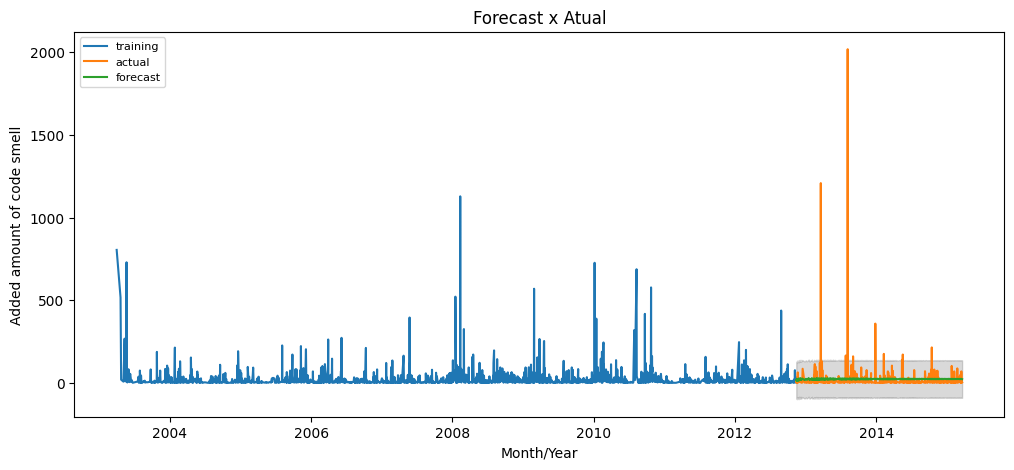

In [1]:
import itertools
import pyodbc
from IPython.core.display import display
from statsmodels.tsa.stattools import kpss
from Query import Query
from configuration import Configuration
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 0)
quantidadeSubSets = int( Configuration.getConfigValue('QUESTION5_METRIC1_SUBSSETS'))
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

#Referencias de publicações sobre a utilização de bibliotecas python para series temporais.
#https://towardsdatascience.com/arima-forecasting-in-python-90d36c2246d3
#https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/


def melhor_aic(data):
    # Grid Search Best AIC
    p = d = q = range(0,8) # p, d, and q can be either 0, 1, or 2
    pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q
    combs = {} # stores aic and order pairs
    aics = [] # stores aics
    # Grid Search continued
    for combination in pdq:
        try:
            model = ARIMA(data, order=combination) # create all possible models
            model = model.fit()
            combs.update({model.aic : combination   }) # store combinations
            aics.append(model.aic)
        except:
           continue
    best_aic = min(aics)
    display("Best AIC: {0} {1}".format(best_aic, combs[best_aic]))
    return combs[best_aic]

def testar_estacionaridade(timeseries):
    adf_test(timeseries)
    kpss_test(timeseries)

def adf_test(series):
     #Perform Dickey-Fuller test:
    display('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    display(dfoutput)
    #O valor p é maior do que o nível de significância 0,05,
    # por isso não é estacionário e diferenciamento é como tal necessário,
    # ou seja. d > 0.
    display(f'Result adf : The series is {"not " if dftest[1] > 0.05 else ""} stationary')
    if dftest[0] > dftest[4]["5%"]:
        display ("Failed to Reject Ho - Time Series is Non-Stationary")
    else:
        display ("Reject Ho - Time Series is Stationary")


def kpss_test(series):
    statistic, p_value, n_lags, critical_values = kpss(series, regression='c', nlags="auto")
    # Format Output
    display('Results of KPSS Test:')
    display(f'KPSS Statistic: {statistic}')
    display(f'p-value: {p_value}')
    display(f'num lags: {n_lags}')
    display(f'Critial Values:')
    for key, value in critical_values.items():
        display(f'   {key} : {value}')
    display(f'Result kpss_test: The series is {"not " if p_value < 0.05 else ""} stationary')


def forecast_accuracy(forecast, actual):
    mapeb = mean_absolute_percentage_error(actual, forecast)
    display({'mape':mapeb})
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],                         actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse,'corr':corr, 'minmax':minmax})


def recuperar_dados_train_test(df):
    registros = len(df)
    qtdTreino = int( registros / 100 * 80)
    qtdTest = registros - qtdTreino
    treino = df.iloc[:qtdTreino]
    teste = df.iloc[qtdTreino:registros]
    display('Observations: %d' % registros + ' Treino: %d' % qtdTreino + ' Teste: %d' % qtdTest)
    return  treino,teste

def recuperar_dataset():
    query = Query.getQuery('query_5_1')
    conn = pyodbc.connect(Configuration.getConfigValue('database_connection'))
    query_result = pd.read_sql_query(query,conn)
    df = pd.DataFrame(query_result)
    df['TOTAL_ADD_CS'].astype('float64')
    df['DATA'] = pd.to_datetime(df['DATA'], dayfirst=True)
    df.sort_values('DATA', inplace=True)
    df.set_index('DATA', inplace=True)
    df.head()
    return df

def forecast(best_aic,train,test,full):
    elements = len(test)
    _train = len(train)
    _test = len(test)

    # Build Model
    model = ARIMA(train, order=best_aic)
    model_fit = model.fit(disp=-1)

    # Forecast
    fc, se, conf = model_fit.forecast(elements,alpha=0.05)  # 95% conf

    #Exibindo os erros
    erros = forecast_accuracy(fc,test["TOTAL_ADD_CS"].values)
    display(erros)

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
    plt.title('Forecast x Atual')
    plt.legend(loc='upper left', fontsize=8)
    plt.ylabel("Added amount of code smell")
    plt.xlabel("Month/Year")
    plt.show()

    # Actual vs Fitted
    #model_full = ARIMA(full, order=best_aic)
    #model_fit_full = model_full.fit(disp=-1)
    #model_fit_full.plot_predict(dynamic=False)
    #display(model_fit.summary())


def main():
    # load dataset
    dados = recuperar_dataset()
    if len(dados) == 0:
        display("No data to analyze")
    else:
        quantidade_total = len(dados)
        quantidade_fold =  int(quantidade_total / quantidadeSubSets)

        #check if data train is stationary]
        testar_estacionaridade(dados['TOTAL_ADD_CS'].values)

        #dados aleatoria para treinar o modelo
        best_aic = {}
        aics = []
        treino  = []
        teste  = []

        for i in range(1,quantidadeSubSets):
            df  = dados.head(quantidade_fold*i)
            #split into train and test sets
            treino, teste  = recuperar_dados_train_test(df)
             #verify best aic
            best_aic =  melhor_aic(treino)
            aics.append(best_aic)

        display(aics)
        best_aic = min(aics)
        display("AIC Selected: {0} ".format(best_aic))

        # Train & Forecast
        forecast(best_aic,treino,teste,dados)


main()